# Voice Assistant

## 1.  Wake word detection

In [1]:
from transformers import pipeline
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

classifier = pipeline(
    "audio-classification", model="MIT/ast-finetuned-speech-commands-v2", device=device
)

In [2]:
classifier.model.config.id2label

{0: 'backward',
 1: 'follow',
 2: 'five',
 3: 'bed',
 4: 'zero',
 5: 'on',
 6: 'learn',
 7: 'two',
 8: 'house',
 9: 'tree',
 10: 'dog',
 11: 'stop',
 12: 'seven',
 13: 'eight',
 14: 'down',
 15: 'six',
 16: 'forward',
 17: 'cat',
 18: 'right',
 19: 'visual',
 20: 'four',
 21: 'wow',
 22: 'no',
 23: 'nine',
 24: 'off',
 25: 'three',
 26: 'left',
 27: 'marvin',
 28: 'yes',
 29: 'up',
 30: 'sheila',
 31: 'happy',
 32: 'bird',
 33: 'go',
 34: 'one'}

In [4]:
from transformers.pipelines.audio_utils import ffmpeg_microphone_live


def launch_fn(wake_word="marvin", prob_threshold=0.5, chunk_length_s=2.0, stream_chunk_s=0.25, debug=False):
    if wake_word not in classifier.model.config.label2id.keys():
        raise ValueError(
            f"Wake word {wake_word} not in set of valid class labels, pick a wake word in the set {classifier.model.config.label2id.keys()}."
        )

    sampling_rate = classifier.feature_extractor.sampling_rate

    mic = ffmpeg_microphone_live(
        sampling_rate=sampling_rate,
        chunk_length_s=chunk_length_s,
        stream_chunk_s=stream_chunk_s,
    )

    print("Listening for wake word...")
    
    for prediction in classifier(mic):
        prediction = prediction[0]
        
        if debug:
            print(prediction)
            
        if prediction["label"] == wake_word:
            if prediction["score"] > prob_threshold:
                return True

In [14]:
launch_fn(debug=False)

Listening for wake word...


True

## 2. Speech transcription

In [26]:
transcriber = pipeline(
    "automatic-speech-recognition", model="openai/whisper-base.en", device=device
)

In [12]:
import sys


def transcribe(chunk_length_s=5.0, stream_chunk_s=1.0):
    sampling_rate = transcriber.feature_extractor.sampling_rate

    mic = ffmpeg_microphone_live(
        sampling_rate=sampling_rate,
        chunk_length_s=chunk_length_s,
        stream_chunk_s=stream_chunk_s,
    )

    print("Start speaking...")
    
    for item in transcriber(mic, generate_kwargs={"max_new_tokens": 128}):
        sys.stdout.write("\033[K")
        print(item["text"], end="\r")
        
        if not item["partial"][0]:
            break

    return item["text"]

In [15]:
transcribe()

Start speaking...


' Hi, my name is Timothy.'

## 3. Language model query

In [16]:
from huggingface_hub import HfFolder
import requests


def query(text, model_id="tiiuae/falcon-7b-instruct"):
    api_url = f"https://api-inference.huggingface.co/models/{model_id}"
    headers = {"Authorization": f"Bearer {HfFolder().get_token()}"}
    payload = {"inputs": text}

    print(f"Querying...: {text}")
    response = requests.post(api_url, headers=headers, json=payload)
    return response.json()[0]["generated_text"][len(text) + 1 :]

In [17]:
query("What does Hugging Face do?")

Querying...: What does Hugging Face do?


'Hugging Face is a Python company that provides a wide range of NLP tools and services. They are most famous for their Hanami tokenizer and ANNIE, which are both used for natural language processing and text analysis.\n\nTo use Hugging Face tools, you need to install the Anaconda, which is a fast and convenient way to upgrade your Python environment on Windows or Mac.'

## 4. Synthesise speech

In [18]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts").to(device)
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)

In [19]:
from datasets import load_dataset

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

In [20]:
def synthesise(text):
    inputs = processor(text=text, return_tensors="pt")
    speech = model.generate_speech(
        inputs["input_ids"].to(device), speaker_embeddings.to(device), vocoder=vocoder
    )
    return speech.cpu()

In [21]:
from IPython.display import Audio

audio = synthesise(
    "Hugging Face is a company that provides natural language processing and machine learning tools for developers."
)

Audio(audio, rate=16000)

## Combine

In [28]:
launch_fn()
transcription = transcribe()
response = query(transcription)
audio = synthesise(response)

Audio(audio, rate=16000, autoplay=True)

Listening for wake word...
Start speaking...
Querying...:  What is machine learning?


In [29]:
from transformers import HfAgent

agent = HfAgent(
    url_endpoint="https://api-inference.huggingface.co/models/bigcode/starcoder"
)

tool_config.json:   0%|          | 0.00/277 [00:00<?, ?B/s]

tool_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

tool_config.json:   0%|          | 0.00/442 [00:00<?, ?B/s]

tool_config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

chat_prompt_template.txt:   0%|          | 0.00/2.83k [00:00<?, ?B/s]

run_prompt_template.txt:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

==Explanation from the agent==
I will use the following  tool: `image_generator` to generate an image of a cat.


==Code generated by the agent==
image = image_generator(prompt="cat")


==Result==


TextToImageTool implements a different description in its configuration and class. Using the tool configuration description.


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

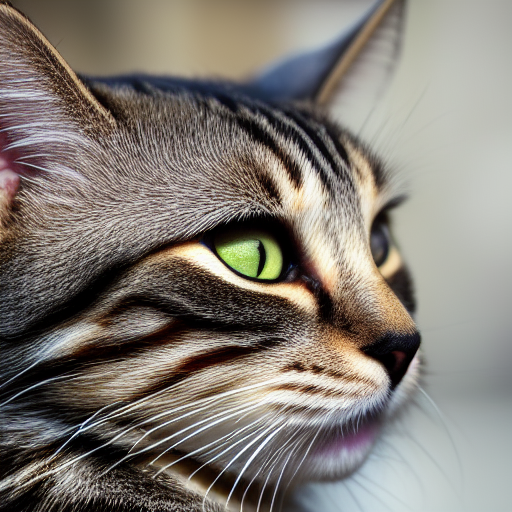

In [31]:
agent.run("Generate an image of a cat")

==Explanation from the agent==
I will use the following  tools: `image_generator` to generate an image, then `image_transformer` to transform the image.


==Code generated by the agent==
image = image_generator(prompt="Space ship on the moon in a cartoon style.")
image = image_transformer(image=image, prompt="Space suits")


==Result==


image_transformation.py:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/spaces/huggingface-tools/image-transformation:
- image_transformation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
ImageTransformationTool implements a different name in its configuration and class. Using the tool configuration name.
ImageTransformationTool implements a different description in its configuration and class. Using the tool configuration description.


  0%|          | 0/25 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

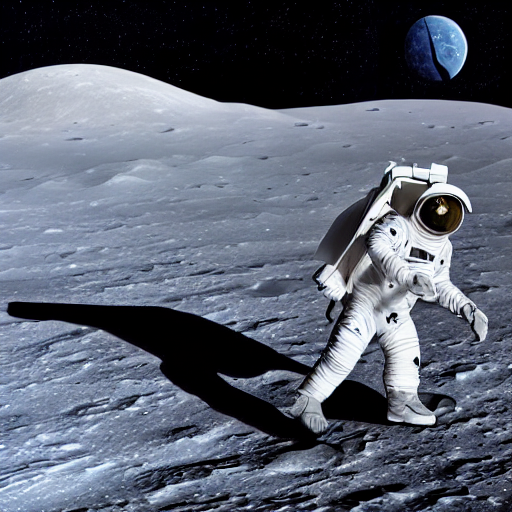

In [32]:
agent.run("Generate an image of a space ship on the moon in a cartoon style. There should be passangers with space suits as well.")

In [ ]:
launch_fn()
transcription = transcribe()
agent.run(transcription)